In [51]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from data_quality import *

In [53]:
clean_flights, dirty_flights = partition_data_files('tmp/FLIGHTS/*.csv')
clean_fb, dirty_fb = partition_data_files('tmp/FBPosts2/*.csv')

In [29]:
clean_flights

['tmp/FLIGHTS/FLIGHTS_clean_734472.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734473.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734474.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734475.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734476.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734478.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734479.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734480.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734481.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734482.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734483.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734484.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734485.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734486.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734487.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734488.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734489.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734490.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734491.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734493.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734495.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734496.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734497.csv',
 'tmp/FLIGHTS/FLIGHTS_clean_734498.csv',
 'tmp/FLIGHTS/FL

In [3]:
flights_clean_completeness_ratio_df, flights_dirty_completeness_ratio_df = completeness_dataframes(clean_flights, dirty_flights)

In [54]:
fb_clean_completeness_ratio_df, fb_dirty_completeness_ratio_df = completeness_dataframes(clean_fb, dirty_fb)

In [8]:
flights_clean_distinct_counts_df, flights_dirty_distinct_counts_df = distinct_counts_dataframes(clean_flights, dirty_flights)

In [55]:
fb_clean_distinct_counts_df, fb_dirty_distinct_counts_df = distinct_counts_dataframes(clean_fb, dirty_fb)

In [56]:
def determine_acceptable_metric_range(batches):
    
    completeness_df, __ = completeness_dataframes(batches, batches)
    distinct_df, __ = distinct_counts_dataframes(batches, batches)
#     return completeness_df
    completeness_means = completeness_df.mean(axis=1)
    completeness_vars = np.sqrt(completeness_df.var(axis = 1, ddof=len(batches)-1))
    completeness_ste = completeness_df.std(axis=1)
    
    completeness_range = pd.DataFrame(columns = ['min', 'max'])
    completeness_range['min'] = completeness_means - 2*completeness_vars
    completeness_range['max'] = completeness_means + 2*completeness_vars
#     completeness_range['min'] = completeness_means - 3*completeness_ste
#     completeness_range['max'] = completeness_means + 3*completeness_ste
    
    distinct_means = distinct_df.mean(axis=1)
    distinct_vars = np.sqrt(distinct_df.var(axis = 1, ddof=len(batches)-1))
    distinct_ste = distinct_df.std(axis=1)
    
    distinct_range = pd.DataFrame(columns = ['min', 'max'])
    distinct_range['min'] = distinct_means - 2*distinct_vars
    distinct_range['max'] = distinct_means + 2*distinct_vars
#     distinct_range['min'] = distinct_means - 3*distinct_ste
#     distinct_range['max'] = distinct_means + 3*distinct_ste
    return completeness_range, distinct_range

In [61]:
def is_acceptable(train_batch, test_batch):
    completeness_range, distinct_range = determine_acceptable_metric_range(train_batch)
    test_batch_completeness, __ = completeness_dataframes(test_batch, test_batch)
    test_batch_distinct, __ = distinct_counts_dataframes(test_batch, test_batch)
    completeness_within_range = 0
    distinct_within_range = 0
#     print(test_batch_distinct)
    for i in range(len(test_batch_distinct.values)):
#         print(test_batch_distinct.values[i][0], distinct_range[i:i+1]['min'].values[0], distinct_range[i:i+1]['max'].values[0])
        if test_batch_distinct.values[i][0] >= (distinct_range[i:i+1]['min'][0]) and test_batch_distinct.values[i][0] <= (distinct_range[i:i+1]['max'][0]):
            distinct_within_range = distinct_within_range + 1
        if test_batch_completeness.values[i][0] >= (completeness_range[i:i+1]['min'][0]) and test_batch_completeness.values[i][0] <= (completeness_range[i:i+1]['max'][0]):
            completeness_within_range = completeness_within_range + 1
    
    
    if completeness_within_range/test_batch_completeness.shape[0] > .8 and distinct_within_range/test_batch_completeness.shape[0] > .8:
        return True
    else:
        return False

In [62]:
## CLEAN F
batch_size = 7
for i in range(len(clean_fb)-batch_size):
    val = is_acceptable(clean_fb[i:i+batch_size], clean_fb[i+batch_size: i+batch_size+1])
    print(val)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [64]:
##DIRTY FB
batch_size = 7
for i in range(len(clean_fb)-batch_size):
    val = is_acceptable(clean_fb[i:i+batch_size], dirty_fb[i+batch_size: i+batch_size+1])
    print(val)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
## CLEAN FLIGHTS
batch_size = 7
for i in range(len(clean_flights)-batch_size):
    val = is_acceptable(clean_flights[i:i+batch_size], clean_flights[i+batch_size: i+batch_size+1])
    print(val)

In [65]:
## DIRTY FLIGHTS
batch_size = 7
for i in range(len(clean_flights)-batch_size):
    val = is_acceptable(clean_flights[i:i+batch_size], dirty_flights[i+batch_size: i+batch_size+1])
    print(val)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


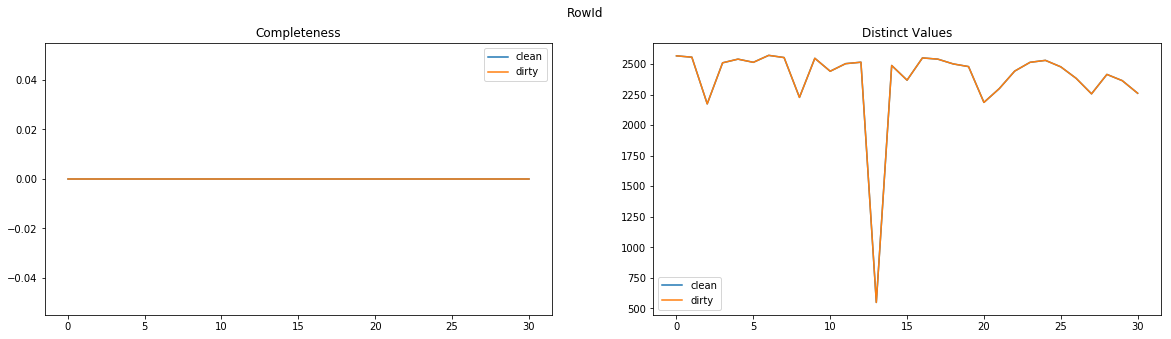

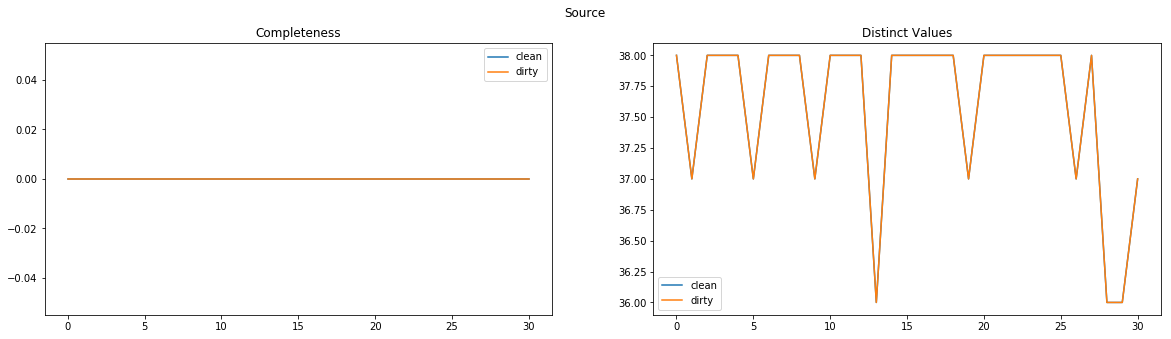

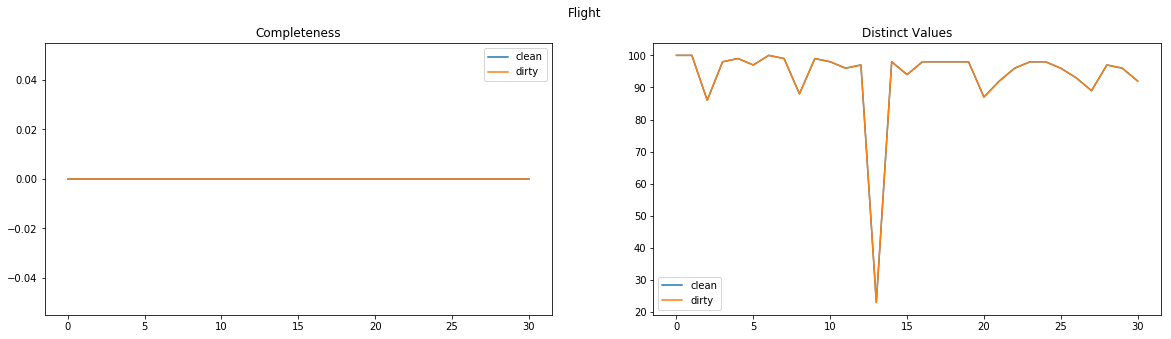

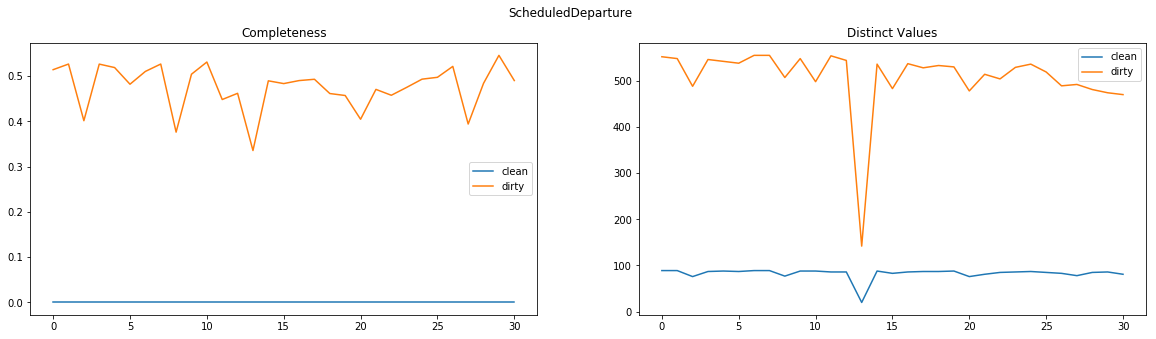

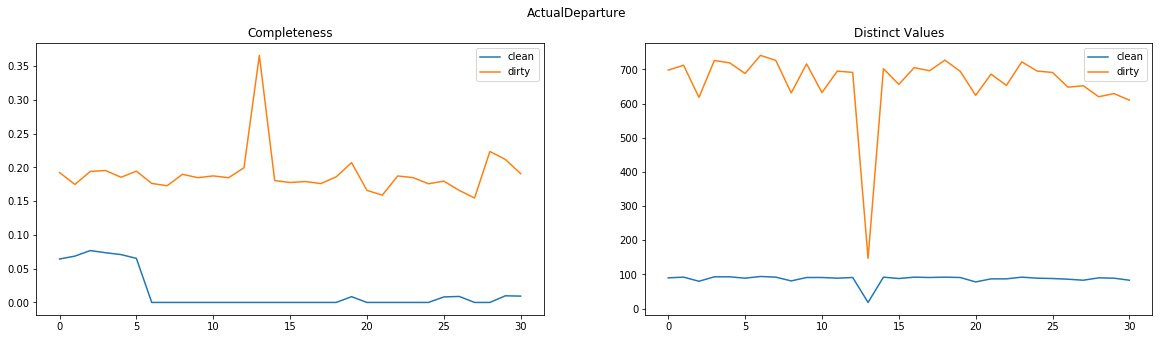

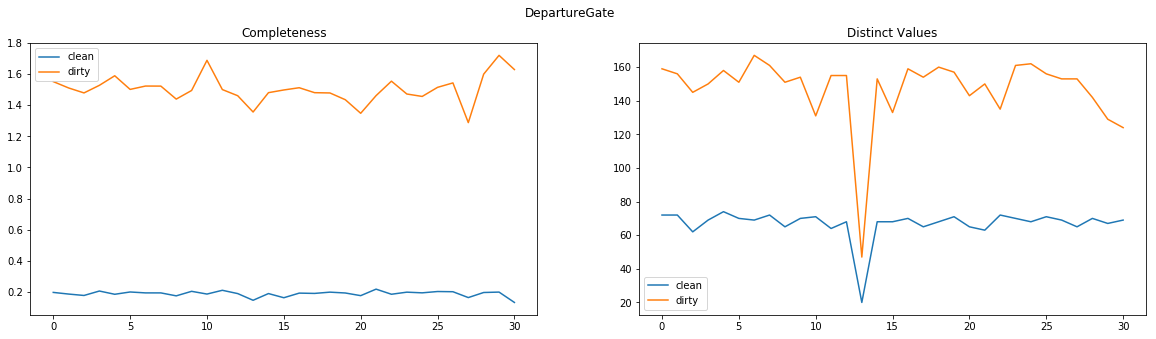

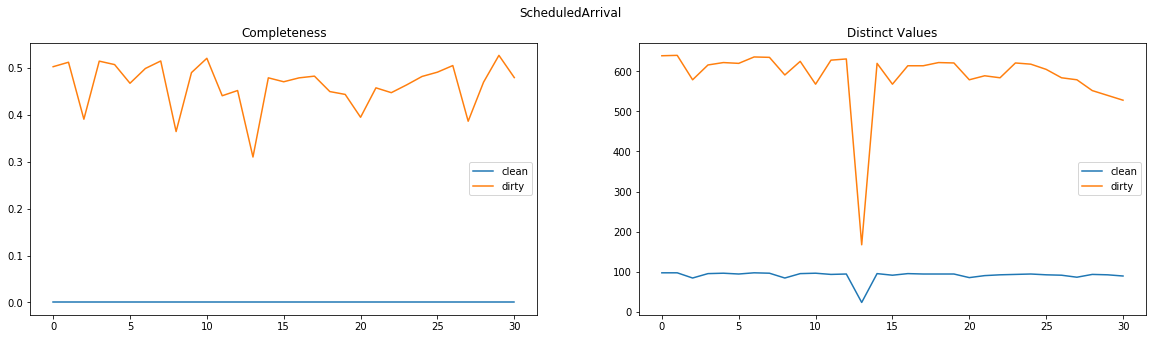

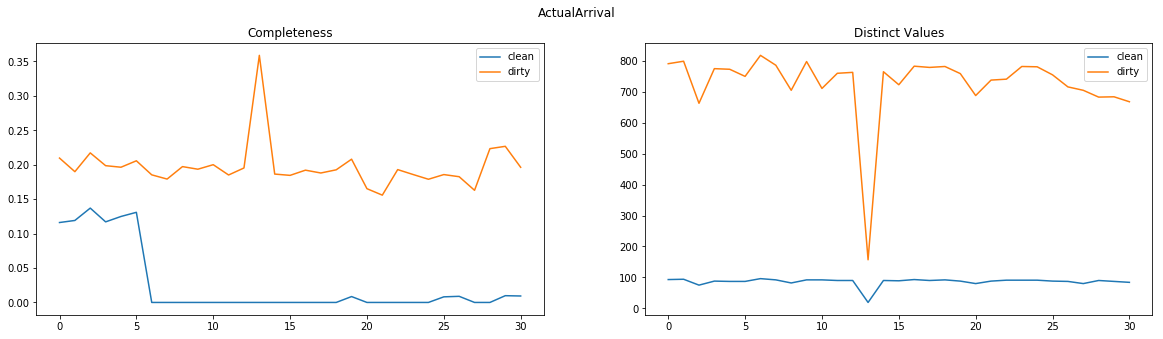

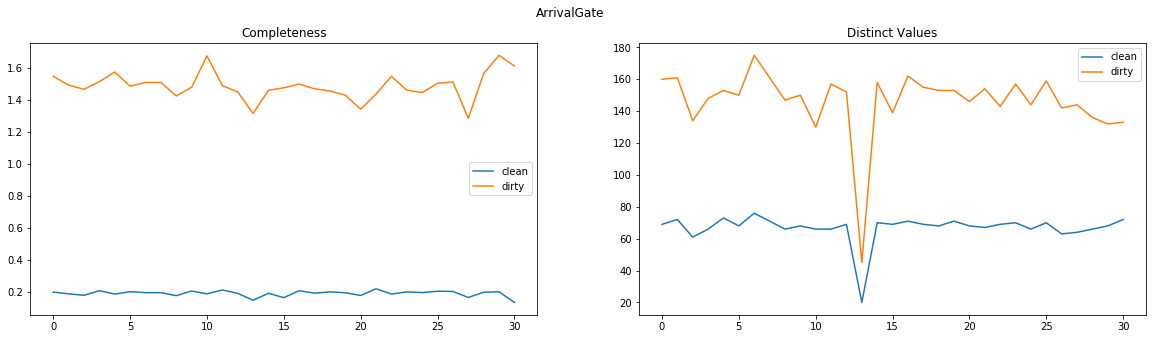

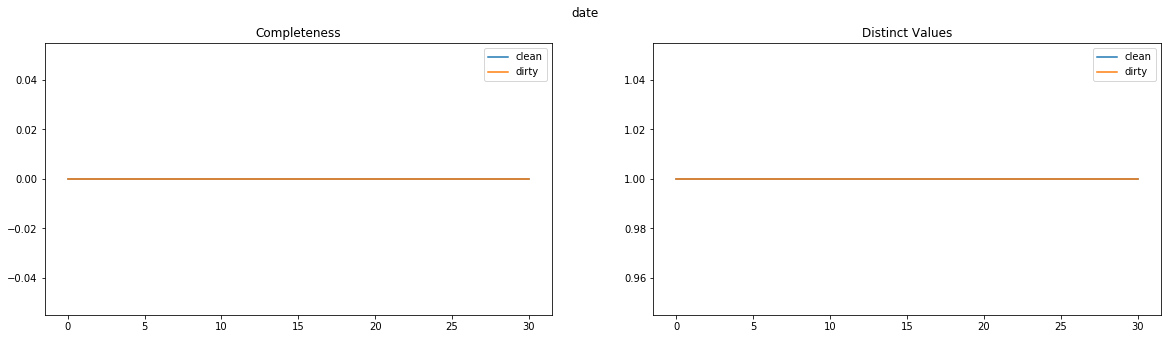

In [9]:
for column in flights_dirty_completeness_ratio_df.index.tolist():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle(column)
    ax1.title.set_text('Completeness')
    ax2.title.set_text('Distinct Values')
    ax1.plot(np.arange(flights_clean_completeness_ratio_df.shape[1]), flights_clean_completeness_ratio_df.loc[column].values, label = 'clean')
    ax1.plot(np.arange(flights_dirty_completeness_ratio_df.shape[1]), flights_dirty_completeness_ratio_df.loc[column].values, label = 'dirty')
    ax2.plot(np.arange(flights_clean_distinct_counts_df.shape[1]), flights_clean_distinct_counts_df.loc[column].values, label = 'clean')
    ax2.plot(np.arange(flights_dirty_distinct_counts_df.shape[1]), flights_dirty_distinct_counts_df.loc[column].values, label = 'dirty')
    ax1.legend()
    ax2.legend()
    plt.show()